# Helpfulness of a product review

The notebook creates classification models of the helpfulness of a customer review. It is trained and evaluated on data where each review is provided with the number of helpfulness votes given by readers.

The data can be obtained at this [page](https://jmcauley.ucsd.edu/data/amazon/), download the file [reviews_Cell_Phones_and_Accessories_5.json.gz](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz) and put it into the same folder as the notebook.

In [1]:
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

from IPython.display import display

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def evaluate_on_test(model, ytest, Xtest):
    """Given a trained model and test data, generate predictions
    and print a report with evaluation results
    """
    yhat = model.predict(Xtest)
    print(classification_report(ytest, yhat))


def print_cv_results(grid_search, col_width=100):
    """Given a grid search object, print a table with the 
    cross-validation results
    """
    results = pd.DataFrame(grid_search.cv_results_
                             )[['params', 'mean_train_score', 'mean_test_score']]
    results["diff, %"] = 100*(results["mean_train_score"]-results["mean_test_score"]
                                                         )/results["mean_train_score"]

    pd.set_option('display.max_colwidth', col_width)
    display(results.sort_values('mean_test_score', ascending=False))

# Load the data

Read the reviews and use only those that received 5 or more helpfulness votes.

We will keep only the text of the review and create a helpfulness score, which is the number of upvotes divided by the total number of votes.

In [3]:
texts = []
targets = []
for line in gzip.open("reviews_Cell_Phones_and_Accessories_5.json.gz", 'r'):
    d = json.loads(line)
    h = d['helpful']
    t = d['reviewText']
    if h[1] < 5:
        continue
    texts.append(t)
    # the helpfulness of a review is the fraction of readers who found the review helpful
    score = h[0]/h[1]
    targets.append(score)

df = pd.DataFrame({"text": texts, "target": targets})

In [4]:
df.shape

(10619, 2)

# Data cleaning and transformation

Using the helpfulness score, we will create helpfulness classes, using the `cut` method of pandas. First, we'll try creating 10 classes using 10 equally spaced "bins":

In [5]:
df["target_cat"] = pd.cut(df["target"], bins=10, labels=[x for x in range(10)])

<AxesSubplot:>

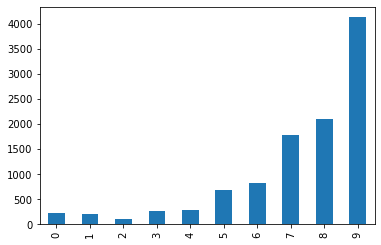

In [6]:
df["target_cat"].value_counts().sort_index().plot(kind="bar")

We see that there are very few reviews that belong to categories reflecting poor helpfulness (categories 0-4), and that there are very many reviews that end up in categories reflecting a lot of helpfulness (categories 7, 8 and 9).

So we'll create 3 bins, with custom bins: reviews with the score between 0 and 0.5 will be put into the class "no" (meaning "not helpful"), between 0.5 and 0.8 will be put into class "undecided", and between 0.8 and 1.0 into the class "yes" (meaning "helpful").

In [7]:
df["target_cat"] = pd.cut(df["target"], bins=[-0.001, 0.5, 0.8, 1.0], labels=["no", "undecided", "yes"])

<AxesSubplot:>

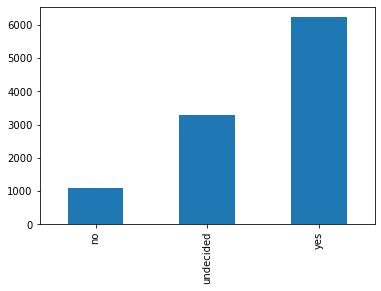

In [8]:
df["target_cat"].value_counts().sort_index().plot(kind="bar")

Now we see that the "no" class still contains around 6 times less reviews than the "yes" class. To simplify things, we will remove the "undecided" class from the data, so the decision between helpful and unhelpful reviews is a clear binary decision.

In [9]:
df = df[df["target_cat"] != "undecided"]

In [10]:
df.reset_index(inplace=True, drop=True)

In [11]:
df.shape

(7325, 3)

There are now 7325 reviews left in the dataset.

Now we'll create a train and test split, using stratfied sampling, to ensure that the target classes have equal distributions in the training and test data.

In [12]:
from sklearn.model_selection import train_test_split

trainset, testset = train_test_split(df, test_size=0.1, 
                                     stratify=df["target_cat"], random_state=7)

Delete the column with numerical helpfulness scores:

In [13]:
del trainset["target"]
del testset["target"]

In [14]:
print(f"{len(trainset)} train and {len(testset)} test instances")

6592 train and 733 test instances


We can inspect a couple of actual reviews and their scores.

In [15]:
pd.set_option('display.max_colwidth', 1000)
trainset.head(10)

,text,target_cat
3648,"Let me say this up front. I would love to have a great Android phone. I love Android's operating system much better than IOS. The flexibility, the interconnection of apps, and screen size all make me love Android phones.The crucial difference is fragmentation and manufacturer support.My wife had the HTC Evo a couple of years ago and HTC did a decent job of patching and updating Android. I had a Samsung Epic 4G and it was a crippled mess with Samsung pushing few updates to the phone, including one that hobbled an already awful GPS.My wife liked her Evo, so when it came time to upgrade, we saw the rather lackluster reports of ""improvements"" forthcoming to the iPhone 5 (we were hoping for a large screen version) and decided to stick with Android and the new Evo, since it was going to be a marked improvement over the Evo my wife found reliable.We got the phone and were pretty happy at first. The Android upgrade and the faster phone meant that it was a joy to operate. We loved the...",yes
5543,I use a silicone cover on my phone and this arm band is big enough to fit the phone with the silicone cover on.,yes
2646,"This isn't the first rechargeable backup battery I've used, but it's the first one that gets all the important things right. First of all it has a generous 2000mAh capacity which is enough to bring my iPhone 3Gs from dead to full power on a single recharge (albeit it is pretty much used up after that). It also delivers USB power at a full 1 amp instead of the slower 500 milliamp that others do, this let you charge finicky items like tablets or completely drained blackberries too. And it's universal USB too, it comes with a cable that charges itself over USB (standard A size to micro), which can be flipped around to the output plug to charge a multitude of micro USB devices (it also has a mini USB adapter included). So it has the open standards pretty much covered which is most Android and feature phones, but if you have an iPhone, Samsung, or other proprietary brand you'll still need your existing data/charge cable to use it. Fortunately I have more than I need from a history of iP...",yes
1334,"Perfect for the AT&T Mifi, which has the stupid annoying design that will shut off wireless when a data cable is connected. Really--who comes up with these brain dead ideas? This is perfect because I can power the Mifi from the USB port all day long.",yes
6308,"All of my previous reviews of wireless headphones were focused around sound quality, noise isolation, and ear tip fitment. Now, here comes a new chapter in wireless headphones with all these rules out of the window. Based on a military technology of bone conduction, AfterShokz were designed to sit outside of your ears conducting the sound through your cheekbones to your inner ear - a shortcut bypassing your eardrums. I know, the description of this process doesn't sound too attractive, but once you get these wraparound headphones on - it will make a perfect sense. I was a bit confused myself reading the description, that's why I couldn't wait to receive my review sample, to test it out, and to share my first hand experience.Once you open the box, the first thing you notice is a very nice and sturdy carrying case which is the size of the box itself. These are not earbuds or some foldable headphones, but rather a full wraparound band headphones with a unique design shape where having...",yes
7076,"Wanted an Apple &#34;certified&#34; charger for my iPhone 5, and this one fits the bill. Well made and charges super fast. I only wish the cord was a little longer -- plugging it into the socket in my glove box make it a little awkward based on length of cord, but it's still a great product.4.5/5 stars",yes
4794,"I installed this screen protector on my husband's GNote II as a test. I understand that the trade-off for an anti-glare screen protector is a bit of hit on perceived clarity and brightness of the screen. Personally, I thought it did a great job of ma

In [16]:
# drop labels for training set, but keep all others
Xtrain = trainset.drop("target_cat", axis=1)
ytrain = trainset["target_cat"].copy()

Xtest = testset.drop("target_cat", axis=1)
ytest = testset["target_cat"].copy()

Next, convert the reviews to a word-document matrix using `CountVectorizer`:

In [17]:
import re

from sklearn.feature_extraction.text import CountVectorizer


def custom_preprocessor(text):
    """Replace all numbers with a symbol
    """
    
    # replace digits
    text = re.compile("\d+").sub("digitsymbol", text)
        
    return text


count_vectorizer = CountVectorizer(
    strip_accents="unicode", # convert accented chars to non-accented versions
    lowercase=True,
    tokenizer=None,        # None - use the default tokenizer
    preprocessor=custom_preprocessor,     # None - use the default preprocessor
    stop_words="english",
    ngram_range=(1,3),     # min and max range of ngrams
    analyzer="word",       # split the document into words, rather than e.g. characters
    max_df=0.9,            # ignore words with df greater than the value (int represents count, 
                           # float represents proportion of documents)
    min_df=5               # ignore words with df lower than the value (int represents count, 
                           # float represents proportion)
)

In [18]:
docs_train_counts = count_vectorizer.fit_transform(Xtrain['text'])

In [19]:
docs_train_counts.shape

(6592, 34584)

In [20]:
docs_test_counts = count_vectorizer.transform(Xtest['text'])

The matrix has been created, but it has a very large number of columns (34,584). This can make all the processing of the data very slow. To deal with this, we will use Latent Semantic Indexing (LSA), which is a technique commonly used in Information Retrieval to represent documents in a compact way while preserving the meaning captured by the word counts. 

LSA involves first weighting each cell in the matrix using TFIDF weights (term frequency multiplied by inverse document frequency, which gives a greater weight to words that (1) appeared a lot in a given document and (2) appeared in few other documents. In this way, the weights encourage words that are prominent in a given document and yet are specific to that document.

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

# fit and transform the training set with "fit_transform()"
docs_train_tfidf = tfidf_transformer.fit_transform(docs_train_counts)

# transform test
docs_test_tfidf = tfidf_transformer.transform(docs_test_counts)

The second step in LSA is to reduce the dimensionality of the matrix using Singular Value Decomposition. Here, we will specify the number of reduced dimensions of the matrix to be 10. The more common value to use is 300, but here we use a much smaller value, for a quick demonstration.

In [22]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(docs_train_tfidf)
X_test_svd = svd.transform(docs_test_tfidf)

Let's make sure the matrix has now only 10 dimensions, but the same number of rows (i.e. each review is now represented as a vector of 10 values):

In [23]:
X_train_svd.shape

(6592, 10)

In [24]:
Xtrain, Xtest = X_train_svd, X_test_svd

# Baseline

Calculate the F-score for the majority baseline (every class label is "yes"):

In [25]:
trainset["target_cat"].value_counts()

yes          5608
no            984
undecided       0
Name: target_cat, dtype: int64

In [26]:
n_yes = trainset["target_cat"].value_counts()["yes"]
n_instances = trainset.shape[0]

In [27]:
# For the "Yes" label, the accuracy measures will be:
yes_precision = n_yes/n_instances
yes_recall = n_yes/n_yes
yes_fscore = 2/(1/yes_precision + 1/yes_recall)

# For the "no" label, it will be:
no_precision = 0.0
no_recall = 0.0
no_fscore = 0.0

# The averages of the two classes, i.e. the eventual baseline scores:
p = (yes_precision+no_precision)/2
r = (yes_recall+no_recall)/2
f = (yes_fscore+no_fscore)/2

print(f"Precision: {p:.5}")
print(f"Recall: {r:.5}")
print(f"F-score: {f:.5}")

Precision: 0.42536
Recall: 0.5
F-score: 0.45967


# Train a model

## Unbalanced data

First, we build a Random Forest model on the unbalanced data.

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# specify the hyperparameters and their values
param_grid = [
    {'n_estimators': [100, 200, 500],
     'max_depth': [5, None]},
]

forest = RandomForestClassifier(random_state=7)

rf_grid_search = GridSearchCV(forest, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

rf_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=7),
             param_grid=[{'max_depth': [5, None],
                          'n_estimators': [100, 200, 500]}],
             return_train_score=True, scoring='f1_macro')

In [29]:
# training and validation RMSE
print_cv_results(rf_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
3,"{'max_depth': None, 'n_estimators': 100}",0.999070,0.526447,47.306306
4,"{'max_depth': None, 'n_estimators': 200}",0.999070,0.525554,47.395622
5,"{'max_depth': None, 'n_estimators': 500}",0.999070,0.522428,47.708528
0,"{'max_depth': 5, 'n_estimators': 100}",0.459672,0.459672,0.000002
1,"{'max_depth': 5, 'n_estimators': 200}",0.459672,0.459672,0.000002
2,"{'max_depth': 5, 'n_estimators': 500}",0.459672,0.459672,0.000002


The best model improved on the baseline, but only a little. Its F-score is 0.519 vs the majority baseline's 0.459.

Let's build a confusion matrix to see what errors the model made. 

The confusion matrix on the training data:

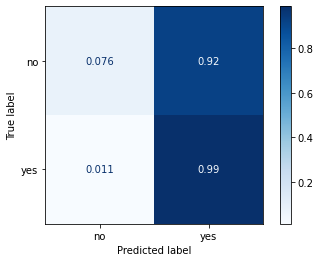

In [30]:
# cross-validation confusion matrix, training data
yhat = cross_val_predict(rf_grid_search.best_estimator_, Xtrain, ytrain, cv=10)
ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=rf_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues)

The confusion matrix on the test data:

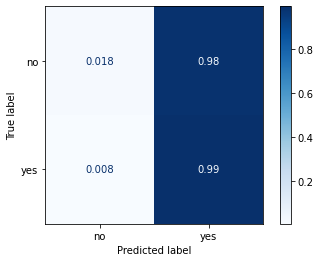

In [31]:
ConfusionMatrixDisplay.from_estimator(rf_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=rf_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

We see that on the test data, the model assigned 97-99% of all test instances - both of the "yes" and "no" class - to the "yes" class. This is the consequence of the training data being very imbalanced: there are much more training examples of the "yes" class than examples of the "no" class. So there is no surprise its F-score is not much different from the one of the majority baseline.

## Random oversampling

We'll first use random oversampling to deal with the imbalanced training data, i.e. copies of instances of the minority class will be added to the training data, with replacement, until a desired balance of the two classes is reached. We will try different desired ratios between the minority and majority class.

To use the oversampling technique, you may need to install the `imblearn` package:

`conda install -c conda-forge imbalanced-learn`

During grid search, we can fine-tune not only the hyperparameters of the classifier, but also the minority/majority ratio of the oversampling method. This can be achieved using the `Pipeline` class of `imblearn`, as follows:

In [32]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

pipeline = Pipeline([
        ('ros', RandomOverSampler(random_state=7)),
        ('rfc', RandomForestClassifier(random_state=7))
    ])

param_grid = [
    {
        'ros__sampling_strategy': [0.5, 0.75, 1.0],
        'rfc__n_estimators': [100, 200, 500],
        'rfc__max_depth': [5, None]
    },
]

ros_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                               scoring='f1_macro',
                               return_train_score=True)

ros_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ros',
                                        RandomOverSampler(random_state=7)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=7))]),
             param_grid=[{'rfc__max_depth': [5, None],
                          'rfc__n_estimators': [100, 200, 500],
                          'ros__sampling_strategy': [0.5, 0.75, 1.0]}],
             return_train_score=True, scoring='f1_macro')

In [33]:
print_cv_results(ros_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
1,"{'rfc__max_depth': 5, 'rfc__n_estimators': 100, 'ros__sampling_strategy': 0.75}",0.652818,0.606404,7.109809
4,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'ros__sampling_strategy': 0.75}",0.654340,0.604610,7.599965
7,"{'rfc__max_depth': 5, 'rfc__n_estimators': 500, 'ros__sampling_strategy': 0.75}",0.655524,0.603968,7.864868
6,"{'rfc__max_depth': 5, 'rfc__n_estimators': 500, 'ros__sampling_strategy': 0.5}",0.629347,0.593186,5.745697
0,"{'rfc__max_depth': 5, 'rfc__n_estimators': 100, 'ros__sampling_strategy': 0.5}",0.627756,0.588803,6.205166
3,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'ros__sampling_strategy': 0.5}",0.628797,0.586154,6.781595
11,"{'rfc__max_depth': None, 'rfc__n_estimators': 100, 'ros__sampling_strategy': 1.0}",0.999103,0.582278,41.719884
14,"{'rfc__max_depth': None, 'rfc__n_estimators': 200, 'ros__sampling_strategy': 1.0}",0.999103,0.574292,42.519236
17,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'ros__sampling_strategy': 1.0}",0.999103,0.572469,42.701660
10,"{'rfc__max_depth': None, 'rfc__n_estimators': 100, 'ros__sampling_strategy': 0.75}",0.999103,0.572175,42.731161


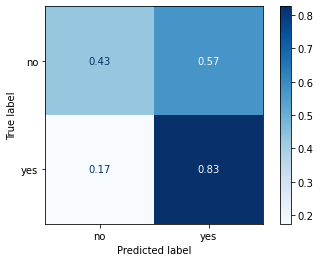

In [34]:
# cross-validation confusion matrix on the training data
yhat = cross_val_predict(ros_grid_search.best_estimator_, Xtrain, ytrain, cv=10)

ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=ros_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues)

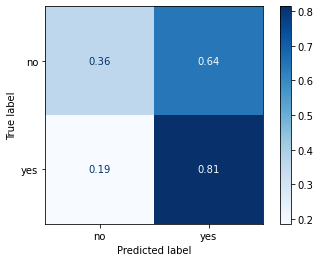

In [35]:
# confusion matrix on the test data
ConfusionMatrixDisplay.from_estimator(ros_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=ros_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Random oversampling produces an cross-validation F-score of 0.606, an improvement on the classifier trained on unbalanced data, which has the F-score of 0.526. 43% of the minority class instances are correctly classified, opposed to just 7% with the latter classifier.

The best minority-majority balance proves to be 0.75.

## SMOTE

Next, we'll try the SMOTE method. It will oversample the minority class by generating synthetic training data of a minority class. 

In [36]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pipeline = Pipeline([
        ('smote', SMOTE(random_state=7)),
        ('rfc', RandomForestClassifier(random_state=7))
    ])

param_grid = [
    {
        'smote__sampling_strategy': [0.5, 0.75, 1.0],
        'rfc__n_estimators': [100, 200, 500],
        'rfc__max_depth': [5, None]
    },
]

os_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

os_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=7)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=7))]),
             param_grid=[{'rfc__max_depth': [5, None],
                          'rfc__n_estimators': [100, 200, 500],
                          'smote__sampling_strategy': [0.5, 0.75, 1.0]}],
             return_train_score=True, scoring='f1_macro')

In [37]:
print_cv_results(os_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
16,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'smote__sampling_strategy': 0.75}",0.999103,0.604550,39.490751
13,"{'rfc__max_depth': None, 'rfc__n_estimators': 200, 'smote__sampling_strategy': 0.75}",0.999103,0.602411,39.704816
4,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'smote__sampling_strategy': 0.75}",0.636011,0.600544,5.576427
7,"{'rfc__max_depth': 5, 'rfc__n_estimators': 500, 'smote__sampling_strategy': 0.75}",0.636938,0.598578,6.022612
1,"{'rfc__max_depth': 5, 'rfc__n_estimators': 100, 'smote__sampling_strategy': 0.75}",0.634858,0.598396,5.743418
15,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'smote__sampling_strategy': 0.5}",0.999103,0.598299,40.116389
17,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'smote__sampling_strategy': 1.0}",0.999070,0.598293,40.115006
3,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'smote__sampling_strategy': 0.5}",0.618877,0.597513,3.452094
10,"{'rfc__max_depth': None, 'rfc__n_estimators': 100, 'smote__sampling_strategy': 0.75}",0.999103,0.597449,40.201454
14,"{'rfc__max_depth': None, 'rfc__n_estimators': 200, 'smote__sampling_strategy': 1.0}",0.999070,0.597210,40.223370


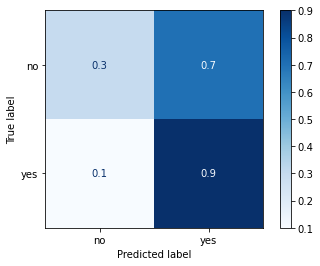

In [38]:
# cross-validation confusion matrix on the training data
yhat = cross_val_predict(os_grid_search.best_estimator_, Xtrain, ytrain, cv=10)

ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=os_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues)

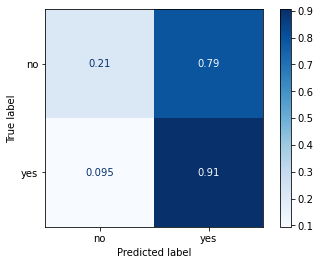

In [39]:
# confusion matrix on the test data
ConfusionMatrixDisplay.from_estimator(os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

One can see that while the model still has a tendency to classify most test instances as "yes", its ratio is much smaller than before: 77% of "no" instances were classified as "yes". This is a big reduction compared to 97% of the classifier trained on unbalanced data.

## Random undersampling

An alternative technique is to undersample the majority class, i.e. remove some training instances of the majority class from the data. As before, we can fine-tune the desired ratio of between the minority and majority classes using grid search.

We'll first try random undersampling.

In [40]:
from imblearn.under_sampling import RandomUnderSampler

pipeline = Pipeline([
        ('rus', RandomUnderSampler(random_state=7)),
        ('rfc', RandomForestClassifier(random_state=7))
    ])


param_grid = [
    {
        'rus__sampling_strategy': [0.5, 0.75, 1.0],
        'rfc__n_estimators': [100, 200, 500],
        'rfc__max_depth': [5, None]
    },
]

rus_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

rus_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('rus',
                                        RandomUnderSampler(random_state=7)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=7))]),
             param_grid=[{'rfc__max_depth': [5, None],
                          'rfc__n_estimators': [100, 200, 500],
                          'rus__sampling_strategy': [0.5, 0.75, 1.0]}],
             return_train_score=True, scoring='f1_macro')

In [41]:
print_cv_results(rus_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
15,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'rus__sampling_strategy': 0.5}",0.890168,0.618284,30.542981
12,"{'rfc__max_depth': None, 'rfc__n_estimators': 200, 'rus__sampling_strategy': 0.5}",0.887443,0.613916,30.821924
9,"{'rfc__max_depth': None, 'rfc__n_estimators': 100, 'rus__sampling_strategy': 0.5}",0.884638,0.613439,30.656495
7,"{'rfc__max_depth': 5, 'rfc__n_estimators': 500, 'rus__sampling_strategy': 0.75}",0.635347,0.598540,5.793239
4,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'rus__sampling_strategy': 0.75}",0.633796,0.595756,6.002055
0,"{'rfc__max_depth': 5, 'rfc__n_estimators': 100, 'rus__sampling_strategy': 0.5}",0.640273,0.595026,7.066798
1,"{'rfc__max_depth': 5, 'rfc__n_estimators': 100, 'rus__sampling_strategy': 0.75}",0.634036,0.594839,6.182247
16,"{'rfc__max_depth': None, 'rfc__n_estimators': 500, 'rus__sampling_strategy': 0.75}",0.773822,0.594340,23.194170
6,"{'rfc__max_depth': 5, 'rfc__n_estimators': 500, 'rus__sampling_strategy': 0.5}",0.640526,0.592168,7.549815
3,"{'rfc__max_depth': 5, 'rfc__n_estimators': 200, 'rus__sampling_strategy': 0.5}",0.639680,0.591433,7.542445


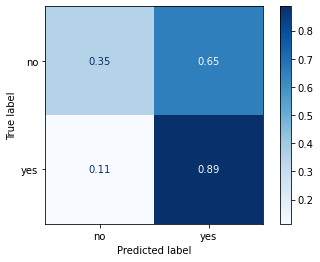

In [42]:
# cross-validation confusion matrix on the training data
yhat = cross_val_predict(rus_grid_search.best_estimator_, Xtrain, ytrain, cv=10)

ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=rus_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues)

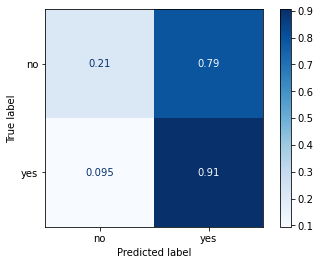

In [43]:
# confusion matrix on the test data
ConfusionMatrixDisplay.from_estimator(os_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=os_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

Judging from the confusion matrices, the classifier tends to mis-classify the minority class, but to a much lesser degree than the classifier trained on the unbalanced data. This also results in an improved F-score.

## Undersampling with Cluster Centroids

In [44]:
from imblearn.under_sampling import ClusterCentroids

pipeline = Pipeline([
        ('cc', ClusterCentroids(random_state=7)),
        ('rfc', RandomForestClassifier(random_state=7))
    ])


param_grid = [
    {
        'cc__sampling_strategy': [0.5, 0.75, 1.0],
        'rfc__n_estimators': [100, 200, 500],
        'rfc__max_depth': [5, None]
    },
]

# we'll use 10-fold cross-validation
us_grid_search = GridSearchCV(pipeline, param_grid, cv=10, 
                              scoring='f1_macro',
                              return_train_score=True)

us_grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cc', ClusterCentroids(random_state=7)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=7))]),
             param_grid=[{'cc__sampling_strategy': [0.5, 0.75, 1.0],
                          'rfc__max_depth': [5, None],
                          'rfc__n_estimators': [100, 200, 500]}],
             return_train_score=True, scoring='f1_macro')

In [45]:
print_cv_results(us_grid_search, col_width=100)

,params,mean_train_score,mean_test_score,"diff, %"
4,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': None, 'rfc__n_estimators': 200}",0.756620,0.590932,21.898353
5,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': None, 'rfc__n_estimators': 500}",0.758930,0.589761,22.290496
3,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': None, 'rfc__n_estimators': 100}",0.754038,0.586581,22.207972
0,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': 5, 'rfc__n_estimators': 100}",0.596981,0.580230,2.805919
2,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': 5, 'rfc__n_estimators': 500}",0.597282,0.579132,3.038808
1,"{'cc__sampling_strategy': 0.5, 'rfc__max_depth': 5, 'rfc__n_estimators': 200}",0.597883,0.577019,3.489705
11,"{'cc__sampling_strategy': 0.75, 'rfc__max_depth': None, 'rfc__n_estimators': 500}",0.673973,0.555236,17.617424
10,"{'cc__sampling_strategy': 0.75, 'rfc__max_depth': None, 'rfc__n_estimators': 200}",0.672515,0.551983,17.922657
9,"{'cc__sampling_strategy': 0.75, 'rfc__max_depth': None, 'rfc__n_estimators': 100}",0.669611,0.550964,17.718699
7,"{'cc__sampling_strategy': 0.75, 'rfc__max_depth': 5, 'rfc__n_estimators': 200}",0.556911,0.537138,3.550492


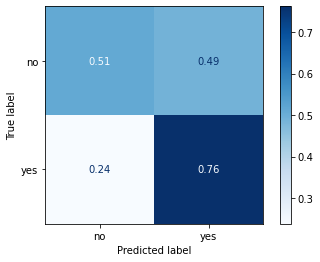

In [46]:
# cross-validation confusion matrix
yhat = cross_val_predict(us_grid_search.best_estimator_, Xtrain, ytrain, cv=10)

ConfusionMatrixDisplay.from_predictions(ytrain, yhat, 
                                        labels=rf_grid_search.best_estimator_.classes_, 
                                        normalize="true",
                                        cmap=plt.cm.Blues)

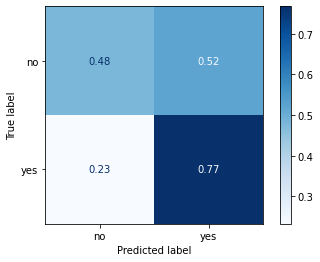

In [47]:
# confusion matrix on the test data
ConfusionMatrixDisplay.from_estimator(us_grid_search.best_estimator_, Xtest, ytest,
                                 display_labels=us_grid_search.best_estimator_.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

As before, this technique improves the F-score on the one achieved with the classifier trained on unbalanced data. There are much fewer misclassifications of the minority class, although this is achieved at the expense of more errors classifying the majority class instances.

# Evaluate on test

Finally, let's compared the performance of the original RF model to those created using over- and under-sampling on the test data:

In [48]:
# Unbalanced data
evaluate_on_test(rf_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

          no       0.29      0.02      0.03       109
         yes       0.85      0.99      0.92       624

    accuracy                           0.85       733
   macro avg       0.57      0.51      0.48       733
weighted avg       0.77      0.85      0.79       733



In [49]:
# Random oversampling
evaluate_on_test(ros_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

          no       0.25      0.36      0.30       109
         yes       0.88      0.81      0.85       624

    accuracy                           0.75       733
   macro avg       0.57      0.59      0.57       733
weighted avg       0.79      0.75      0.76       733



In [50]:
# SMOTE
evaluate_on_test(os_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

          no       0.28      0.21      0.24       109
         yes       0.87      0.91      0.89       624

    accuracy                           0.80       733
   macro avg       0.57      0.56      0.56       733
weighted avg       0.78      0.80      0.79       733



In [51]:
# Random undersampling
evaluate_on_test(rus_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

          no       0.34      0.28      0.31       109
         yes       0.88      0.90      0.89       624

    accuracy                           0.81       733
   macro avg       0.61      0.59      0.60       733
weighted avg       0.80      0.81      0.80       733



In [52]:
# Undersampling with Cluster Centroids
evaluate_on_test(us_grid_search.best_estimator_, ytest, Xtest)

              precision    recall  f1-score   support

          no       0.26      0.48      0.34       109
         yes       0.89      0.77      0.83       624

    accuracy                           0.72       733
   macro avg       0.58      0.62      0.58       733
weighted avg       0.80      0.72      0.75       733



The results appear to be very similar to those obtained on the validation data: both over- and undersampling improve the quality of the classifiers, and they both achieve similar values of the F-score.